# Denoising Auto Encoder

By: Chengyi (Jeff) Chen

## Objective

In this notebook, we will accomplish the following:
1. Generate noisy images from this [repo](https://github.com/Belval/TextRecognitionDataGenerator) using the names of the currently active businesses in LA
2. Implement a denoising auto encoder to clean / repair the augmented / noisy images so that we can feed the cleaned images into an OCR (Google's) for text recognition

## Motivation

- In order to identify the diversity demographic makeup of currently operating businesses in different parts of LA.

## Data

- To generate a list of relevant images like store names in LA, we will first pull the list of active businesses in LA from data.lacity.org and feed those names into our image generator, subsequently augmenting the simulated store sign images to be blocked by obstacles such as branches, trees, lamposts, etc... so that we have a representative training set that will \be fed into our denoising autoencoder.

---
## Library imports

In [1]:
# General Utilities
import re
import os
import sys
import random
import subprocess
from PIL import Image
from PIL import ImageDraw

# ML / Deep learning Utilities
import numpy as np
from numpy import loadtxt
from pylab import rcParams
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
%matplotlib inline

/Users/jeffchenchengyi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


---
## Downloading Dataset
__We will first grab the list of all active businesses in LA from [data.lacity.org](https://dev.socrata.com/foundry/data.lacity.org/ngkp-kqkn)__

In [2]:
# Download data into data/lacity in the current directory
# run !ls data/lacity to see the csv it downloaded
!wget --directory-prefix=data/lacity/ -Nq https://data.lacity.org/api/views/6rrh-rzua/rows.csv

In [3]:
# declare directory to write results and file to read data from
LACITY_DATA_LOC = 'data/lacity/rows.csv'

__Let's checkout the dataset__

In [4]:
raw_df = pd.read_csv(LACITY_DATA_LOC)
raw_df.head()

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION
0,0000000115-0001-3,VINCENZO LABELLA,NaN,521 SWARTHMORE AVENUE,PACIFIC PALISADES,90272-4350,521 SWARTHMORE 90272-4350,521 SWARTHMORE AVENUE,PACIFIC PALISADES,90272-4350,561500.0,Travel arrangement & reservation services,11,01/01/1990,NaN,NaN
1,0000000150-0001-5,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,NaN,2015 W TEMPLE STREET,LOS ANGELES,90026-4913,2015 TEMPLE 90026-4913,2607 VAN BUREN PLACE,LOS ANGELES,90007-2129,611000.0,"Educational services (including schools, colle...",13,01/01/1991,NaN,NaN
2,0000000156-0001-2,SPRINGBOARD NON-PROFIT CONSUMER CREDIT MANAGEMENT,MONEY MANAGEMENT INTERNATIONAL,1605 W OLYMPIC BLVD #9023,LOS ANGELES,90015-3828,1605 OLYMPIC 90015-3828,NaN,NaN,NaN,523900.0,Other financial investment activities (includi...,1,02/01/1999,NaN,NaN
3,0000000247-0001-1,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,NaN,3806 W PICO BLVD,LOS ANGELES,90019-4304,3806 PICO 90019-4304,2607 VAN BUREN PLACE,LOS ANGELES,90007-2129,611000.0,"Educational services (including schools, colle...",10,01/01/1991,NaN,NaN
4,0000000267-0001-9,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,NaN,3115 VENICE BLVD,LOS ANGELES,90019-6238,3115 VENICE 90019-6238,2607 VAN BUREN PLACE,LOS ANGELES,90007-2129,611000.0,"Educational services (including schools, colle...",10,01/01/1991,NaN,NaN


__Seems like Business name is what we really need as it is the title that would likely appear on the storefront__

In [5]:
raw_df['BUSINESS NAME'].head(10)

0                                     VINCENZO LABELLA
1        A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C
2    SPRINGBOARD NON-PROFIT CONSUMER CREDIT MANAGEMENT
3        A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C
4        A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C
5        A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C
6        A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C
7        A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C
8        A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C
9                                     CORALIE WHITCOMB
Name: BUSINESS NAME, dtype: object

__There are duplicate Business names in the dataset, so let's remove them and store in a list__

In [6]:
# Getting only the unique business names and removing the weird "/C"s
business_names = [name[:-3] if name[-3:] == ' /C' or name[-2:] == '/C' else name for name in raw_df['BUSINESS NAME'].unique()]

# TODO: Escaping the "/" in the names to prevent it 
# from messing up the name format later on
'''
    Use Regex to escape "/" because the TextRecognitionDataGeneretor can't escape it
'''

# How many active businesses in LA
print('Number of active businesses in LA: %d' % len(business_names))
business_names

Number of active businesses in LA: 482884


['VINCENZO LABELLA',
 'A A OFICINA CENTRAL HISPANA DE LOS ANGELES',
 'SPRINGBOARD NON-PROFIT CONSUMER CREDIT MANAGEMENT',
 'CORALIE WHITCOMB',
 'NEW CITY LIFE FOUNDATION',
 'LOS ANGELES URBAN LEAGUE HEAD START STATE PRESCHOOL',
 'THE KABBALAH CENTRE INTERNATIONAL INC',
 'JOYCE WILLING',
 'JOSE DEJESUS SOLTERO',
 'THE SKID ROW HOUSING TRUST',
 'THE PUBLIC HEALTH FOUNDATION OF LOS ANGELES COUNTY INC',
 'ST ANTHONY MEDICAL CENTER',
 'YIDDISHKAYT LOS ANGELES',
 'S RICHARD FRIESEN',
 'SAN FERNANDO VALLEY COMMUNITY MENTAL HEALTH CENTER INC',
 'WET PAINT PRODUCTIONS LLC',
 'JESSICA STRAUS',
 "CALIFORNIA CHILDREN'S ACADEMY",
 'LAS PALMAS FOUNDATION',
 'ODILIA TRUJILLO',
 'DARIUSH DIVSALAR',
 'ATLANTIC RECOVERY SERVICES',
 'NATIONAL HOUSING DEVELOPMENT CORPORATION',
 'JULIE CONN',
 'WORLD IMPACT',
 'TARZANA TREATMENT CENTER INC',
 'JUN CHEN QUACH CHAN',
 'ROBIN DOUGLASS SHARP',
 'DEBORAH SMITH',
 'SHALOM CENTER FOR T EE OF LIFE',
 'NET US SOLUTION INC',
 'CASA VELA INC',
 'NATAN FABRIC INC',
 '

__Let's write these names into a .txt file which we will use for the image generation__

In [7]:
# Location of .txt files that can be used 
# for the text image data generation
DICT_LOC = './dicts/sp.txt'

# Remove any old la_active_business_names.txt
subprocess.call(['rm', '-rf', DICT_LOC])

# Writing all the active LA business names
# into the .txt file
with open(DICT_LOC, 'w') as f:
    for idx, name in enumerate(business_names):
        f.write("%s\n" % name)
        
    f.close()

---
## Data Generation
__Now let's use the [TextRecognitionDataGenerator](https://github.com/Belval/TextRecognitionDataGenerator) to generate images of those active LA Business names. Firstly, we will create 8 images for each business name and store it in a folder for original images. Secondly, we will augment all of the images with random rotations, line streaks to cover parts of the image, etc... and store them in a folder for altered images which we will use to feed into the denoising auto encoder as the input. The original images will be treated as the true outputs that our denoised images will be compared to, determing the loss.__

In [8]:
# Directory of where our training / testing
# dataset will be stored
TRAIN_LOC = './data/training'
TEST_LOC = './data/testing'

# Remove any old data for training / testing
subprocess.call(['rm', '-rf', TRAIN_LOC])
subprocess.call(['rm', '-rf', TEST_LOC]);

__Let's generate the original images for training and test set - we would like a 80% training, 20% testing split for the data, so with 482,884 business names, and 8 images for each business name in the original image set, we would generate 3,863,072 images for our training set and 965,768 images for our testing set (P.S. Now I'm only creating 10,000 images to try out)__

In [9]:
%%time
# Directory of the run.py file for TextRecognitionDataGenerator
# & original images for training
DATAGEN_LOC = '../TextRecognitionDataGenerator/TextRecognitionDataGenerator/run.py'
TRAIN_SIZE = 8000
TEST_SIZE = 2000

# Original TRAINING images are named [INDEX].jpg
subprocess.call(['python', 
                 DATAGEN_LOC, 
                 '--output_dir', 
                 TRAIN_LOC + '/original', 
                 '-na' , '2' ,
                 '-l', 'sp', 
                 '-c', str(TRAIN_SIZE), 
                 '-w', '1']);

# Original TESTING images are named [INDEX].jpg
subprocess.call(['python', 
                 DATAGEN_LOC, 
                 '--output_dir', 
                 TEST_LOC + '/original', 
                 '-na' , '2' ,
                 '-l', 'sp', 
                 '-c', str(TEST_SIZE), 
                 '-w', '1']);

CPU times: user 2.24 ms, sys: 10.5 ms, total: 12.7 ms
Wall time: 42.3 s


---
## Data Augmentation
__Now we will perform random augmentations on our original dataset and we will use this to feed into our denoising autoencoder - For every single original image, we will draw a random line in the image that may or may not cover the characters and a rotation__

In [52]:
# Helper function to create a new folder
def mkdir(path):
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
        else:
            print("(%s) already exists" % (path))
            
# Create new directories for the augmented images
mkdir(TRAIN_LOC + '/augmented')
mkdir(TEST_LOC + '/augmented')

# Training set
for i in range(TRAIN_SIZE):
    img = Image.open(TRAIN_LOC + '/original/%d.jpg' % i).rotate(np.random.randint(20))
    w = random.randint(1, img.size[1]/2)
    x1 = random.randint(0, img.size[0])
    y1 = random.randint(0, img.size[1])
    x2 = random.randint(0, img.size[0])
    y2 = random.randint(0, img.size[1])
    img_draw = ImageDraw.Draw(img)
    img_draw.line([(x1, y1), (x2, y2)], width=w, fill='brown')
    img.save(TRAIN_LOC + '/augmented/%d.jpg' % i)


# Testing set
for i in range(TEST_SIZE):
    img = Image.open(TEST_LOC + '/original/%d.jpg' % i).rotate(np.random.randint(20))
    w = random.randint(1, img.size[1]/2)
    x1 = random.randint(0, img.size[0])
    y1 = random.randint(0, img.size[1])
    x2 = random.randint(0, img.size[0])
    y2 = random.randint(0, img.size[1])
    img_draw = ImageDraw.Draw(img)
    img_draw.line([(x1, y1), (x2, y2)], width=w, fill='brown')
    img.save(TEST_LOC + '/augmented/%d.jpg' % i)

(./data/training/augmented) already exists
(./data/testing/augmented) already exists


---
## Data Pre-processing
__Now that we have both the original unobstructed images and the augmented images, we can now take a look at the images as well as reshape them for our denoising auto encoder__

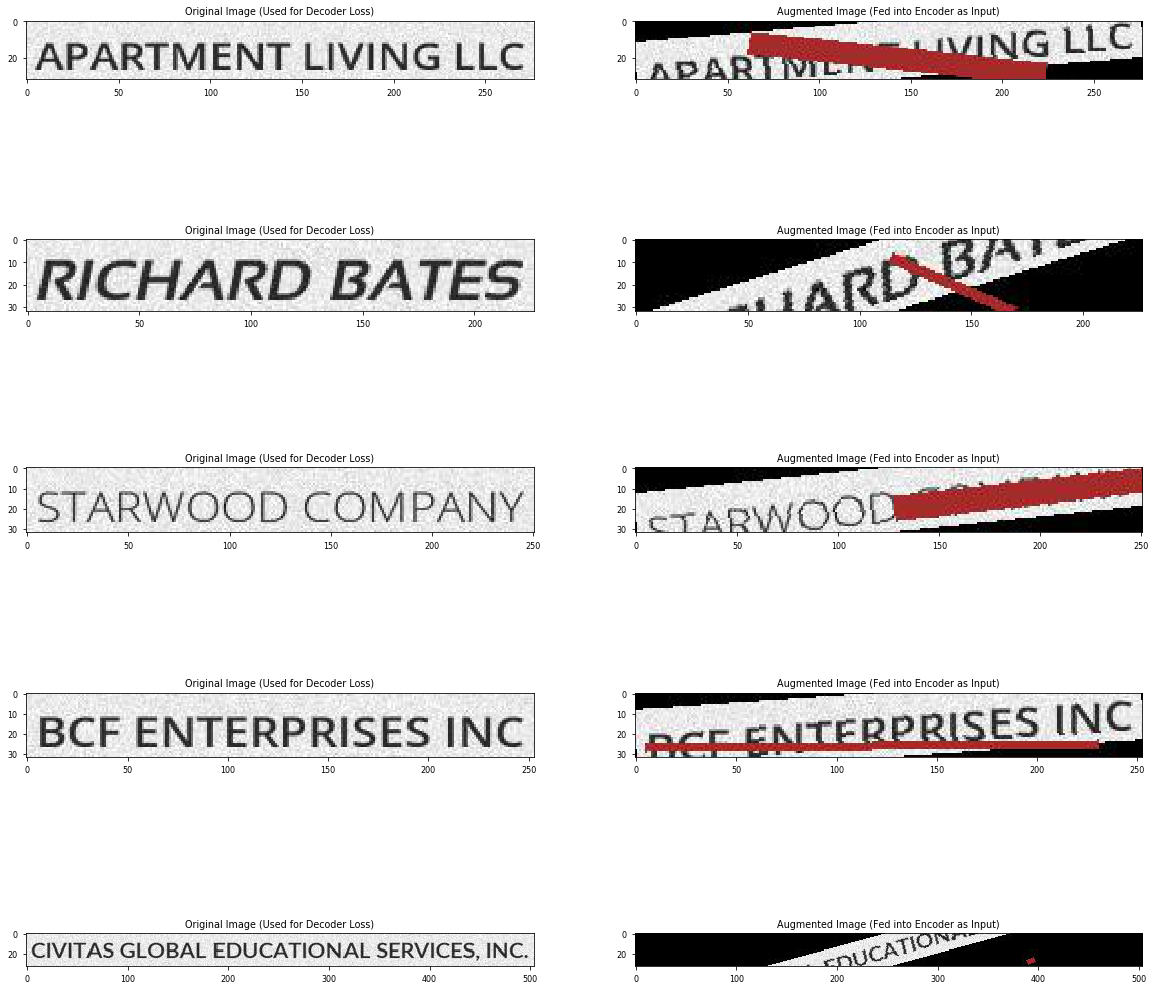

In [53]:
# Read an example Image from the training set with matplotlib
import matplotlib.image as mpimg 

# Random idx for us to see the original and augmented image
rand_idx = random.randint(0, TRAIN_SIZE)
  
# Output Images Settings
rcParams['figure.figsize'] = 20,20
fig, ax = plt.subplots(5,2)

# Displaying a list of the originals and augmented side by side
for row_idx in range(5):
    
    img_original = mpimg.imread(TRAIN_LOC + '/original/%d.jpg' % (rand_idx + row_idx)) 
    img_augmented = mpimg.imread(TRAIN_LOC + '/augmented/%d.jpg' % (rand_idx + row_idx)) 

    # Original Image
    ax[row_idx, 0].set_title('Original Image (Used for Decoder Loss)')
    ax[row_idx, 0].imshow(img_original)

    # Augmented Image
    ax[row_idx, 1].set_title('Augmented Image (Fed into Encoder as Input)')
    ax[row_idx, 1].imshow(img_augmented)
    
plt.show();

__Since all the images are of different sizes, let's resize them__

In [75]:
# TODO: Resize and save the images
# X_train = 
# X_test = 

Using TensorFlow backend.


---
## Denoising Auto Encoder Model
__We will build our denoising auto encoder now, we use this article as our [reference](https://medium.com/@connectwithghosh/denoising-images-using-an-autoencoder-using-tensorflow-in-python-1e2e62932837)__

__Number of nodes in each layer__

In [76]:
# Encoder 
num_nodes_input = 784
num_nodes_hidden_encoder = 32

# Decoder
num_nodes_hidden_decoder = 32
num_nodes_output  = 784

__Model Layers__

In [ ]:
# Input Layer: Taking in images of shape 784
input_layer = tf.placeholder('float', [None, num_nodes_input])

# Hidden Layer (Encoder): 784*32 weights and 32 biases
hidden_layer_encoder_vals = {
    'weights': tf.Variable(tf.random_normal([num_nodes_input, num_nodes_hidden_encoder])),
    'biases': tf.Variable(tf.random_normal([num_nodes_hidden_encoder]))  
}

# Hidden layer (Decoder): 32*32 weights and 32 biases
hidden_layer_decoder_vals = {
    'weights': tf.Variable(tf.random_normal([num_nodes_hidden_encoder, num_nodes_hidden_decoder])),
    'biases': tf.Variable(tf.random_normal([num_nodes_hidden_decoder]))  
}

# Output layer: 32*784 weights and 784 biases
output_layer_vals = {
    'weights':tf.Variable(tf.random_normal([num_nodes_hidden_decoder, num_nodes_output])), 
    'biases':tf.Variable(tf.random_normal([num_nodes_output])) 
}

# Sigmoid activation on input layer values 
# and hidden layer of encoder
encoding_layer = tf.nn.sigmoid(
    tf.add(
        tf.matmul(
            input_layer,
            hidden_layer_encoder_vals['weights']
        ),
        hidden_layer_encoder_vals['biases']
    )
)

# Sigmoid activation on output of encoding layer 
# and the hidden layer of decoder
decoding_layer = tf.nn.sigmoid(
    tf.add(
        tf.matmul(
            layer_1,
            hidden_2_layer_vals['weights']
        ),
        hidden_2_layer_vals['biases']
    )
)

# Multiply output of decoding layer with the output layer values
# with Weight and add Bias
output_layer = tf.matmul(
    decoding_layer,
    output_layer_vals['weights']
) + output_layer_vals['biases']

# Output_true shall have the original image for error calculations
output_true = tf.placeholder('float', [None, 784])

__Loss Function__

In [ ]:
# Defining our cost function as MSE
mse = tf.reduce_mean(tf.square(output_layer - output_true))

__Optimizer__

In [ ]:
# Defining our optimizer: How fast the model should learn
learn_rate = 0.1
optimizer = tf.train.AdagradOptimizer(learn_rate).minimize(mse)

__Create Session__

In [ ]:
# Initialising session
init = tf.global_variables_initializer()

In [ ]:
with tf.Session() as sess:
    
    sess.run(init)
    
    # Defining batch size, number of epochs and learning rate
    batch_size = 100  # how many images to use together for training
    hm_epochs =1000    # how many times to go through the entire dataset
    tot_images = X_train.shape[0] # total number of images

    # Running the model for a 10000 epochs taking 100 images in batches
    # total improvement is printed out after each epoch
    for epoch in range(hm_epochs):
        
        # Initializing error as 0
        epoch_loss = 0 
        
        for i in range(int(tot_images/batch_size)):
            epoch_x = X_train[i * batch_size : (i + 1) * batch_size]
            _, c = sess.run([optimizer, meansq],\
                   feed_dict={input_layer: epoch_x, \
                              output_true: epoch_x})
            epoch_loss += c
            
        print('Epoch', epoch, '/', hm_epochs, 'loss:',epoch_loss)
        
    # Test the Train Model
#     matches = 
    
#     accuracy = 
    
#     print(sess.run(accuracy, feed_dict={x: ,
#                                         y_true: }))

In [ ]:
# pick any image
any_image = X_test_noisy[234]

# run it though the autoencoder
output_any_image = sess.run(output_layer,\
                   feed_dict={input_layer:[any_image]})